# Библиотеки

In [19]:
!pip install cryptorandom permute arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.3/154.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 7.1 MB/s eta 0:00:00


In [20]:
from zlib import crc32

import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.stats.descriptivestats import sign_test
from permute.core import one_sample
from arch.bootstrap import IIDBootstrap

import warnings
warnings.filterwarnings("ignore")

# Код генерации выборки

In [2]:
import re
EMAIL_REGEX = re.compile(r"[^@]+@phystech.edu")

def generate_dataset(code):
    rs = np.random.RandomState(code%(2**32-1))
    ars = np.random.RandomState(code%(2**16-1))
    if rs.randint(low=0, high=2) == 0:
        while True:
            data = rs.randn(20)
            if st.shapiro(data)[1] > 0.2 or ars.binomial(100, 0.05) > 10:
                break
    else:
        while True:
            data = np.concatenate([rs.randn(6) - 2, rs.randn(6) + 2])
            if st.shapiro(data)[1] < 0.01 or ars.binomial(100, 0.05) > 10:
                break
    return data

# Генерация выборки для вашей почты

<span style="color:red">
    ВАЖНО!
    Почта, которую укажете ниже и почта с которой Вы отправляете домашнее задание должна совпадать!
    В момент проверки задания алгоритм генерирует выборку на основе почты из анкеты!
</span>

Внимательно проверьте почту для которой выполняется задание!

In [3]:
task = dict()
task['mail'] = input(prompt='Enter your mail: ')
assert EMAIL_REGEX.match(task['mail']), 'Not a mail in the phystech.edu domain'
task['id'] = crc32(task['mail'].encode('utf-8'))
task['data'] = generate_dataset(task['id'])

task

Enter your mail: egorov.sa@phystech.edu


{'mail': 'egorov.sa@phystech.edu',
 'id': 1581189463,
 'data': array([-2.99333718, -2.40980958, -2.74811145, -2.36947195, -0.85843079,
        -1.28529119,  0.37565865,  2.96031207,  0.662167  ,  2.82958842,
         0.74881247,  2.27586831])}

# Работа с выборкой

In [4]:
data = pd.DataFrame(task['data'])
data.describe()

,0
count,12.000000
mean,-0.234337
std,2.189927
min,-2.993337
25%,-2.379556
50%,-0.241386
75%,1.130576
max,2.960312


<Axes: ylabel='Density'>

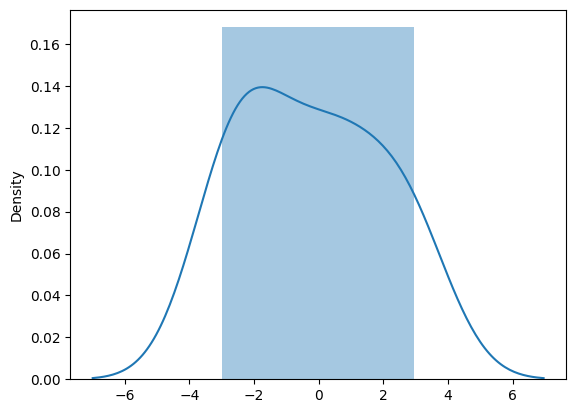

In [12]:
sns.distplot(data)

## Можно ли отклонить гипотезу о нормальности выборки, используя критерий Шапиро-Уилка (p<=0.05)?

In [13]:
print('p-value = {:.2f}'.format(st.shapiro(data)[1]))

p-value = 0.21


`p-value` явно указывает, что гипотезу о нормальности не отконяем

## Знаково-ранговый критерий Уилкоксона

In [17]:
_, p = st.wilcoxon(data)
round(p[0], 2)

0.68

In [18]:
_, p = sign_test(data)
round(p, 2)

1.0

И снова нулевую гипотезу не отвергаем

## Доверительный интервал

In [30]:
T = data - 0.5
t = sum(T)
count = 0
good = 0
for v in itertools.product([-1, 1], repeat = len(data)):
    count +=1
    stat = np.dot(T[0], v)
    if stat<=t:
        good+=1


good

2048

In [31]:
bs = IIDBootstrap(data)
list(map(lambda x: round(x[0], 2), bs.conf_int(np.mean, 1000, method='basic')))

[-1.41, 0.99]